In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from numpy import asarray
from PIL import Image
import time as t
import math as m
from scipy import linalg as LA

# https://github.com/twaclaw/matmult/blob/master/hls/matmult.h#L19
# data recreation
# scalability

# Generating Random 128x128 Dataset

In [2]:
DIM1 = 128
DIM2 = 128
X = np.random.uniform(10, 1000, size = (DIM1, DIM2))   # Generate a dummy dataset

In [3]:
# small test data for comparison with scikit learn's implementation (standard)
TestData = np.array([
        [0.387, 4878, 5.42],
        [0.723, 12104, 5.25],
        [1, 12756, 5.52]
    ])

# 

# Attaching Custom overlay

In [4]:
from pynq import (allocate, Overlay)

ol = Overlay('matmult.bit')

dma = ol.dma
mmult_ip = ol.accel

DIM1 = 128
DIM2 = 128

in_buffer = allocate(shape=(2, DIM1, DIM2), dtype=np.float32, cacheable=True)
out_buffer = allocate(shape=(DIM1, DIM2), dtype=np.float32, cacheable=True)

In [5]:
# // default control generated by vivado for AXI based IP
# // 0x00 : Control signals
# //        bit 0  - ap_start (Read/Write/COH)
# //        bit 1  - ap_done (Read/COR)
# //        bit 2  - ap_idle (Read)
# //        bit 3  - ap_ready (Read)
# //        bit 7  - auto_restart (Read/Write)
# //        others - reserved

CTRL_REG = 0x00
AP_START = (1<<0) # bit 0
AUTO_RESTART = (1<<7) # bit 7
mmult_ip.register_map.k = DIM1
mmult_ip.register_map.m = DIM2
mmult_ip.register_map.n = DIM1


def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    mmult_ip.write(CTRL_REG, (AP_START | AUTO_RESTART))  # initialize the module
    dma.sendchannel.wait()
    dma.recvchannel.wait()

# 

# PCA computation functions

In [6]:
def covariance(data):
    data -= np.mean(data, axis = 0)  
    cov = np.cov(data, rowvar = False)
    return cov, data

In [7]:
def eigenVal(cov_mat):
    eigen_values , eigen_vectors = LA.eigh(cov_mat)
    idx = np.argsort(eigen_values)[::-1]
    eigen_vectors = eigen_vectors[:,idx]
    eigen_values = eigen_values[idx]
    return eigen_vectors #returning sorted eigen vectors

In [8]:
def dimRed(n, sorted_eigenvectors, X_center):
#     eigenvector_subset = sorted_eigenvectors[:,0:n]
    projection = np.dot(X_center, sorted_eigenvectors)
#     projection = np.dot(X_center, eigenvector_subset)
    return projection


def dimRedPL(n, sorted_eigenvectors, X_center):
    in_buffer[:] = np.stack((X_center, sorted_eigenvectors))
    run_kernel()
    return out_buffer

In [9]:
Cov, centerData = covariance(X)
eignVecInOrder = eigenVal(Cov)
def PCA(X, dimension= 3, Flag = True):
    if Flag:
        # with PL
        out = dimRedPL(dimension, eignVecInOrder, centerData)[:dimension]
        
    else:
        #only CPU
        out = dimRed(dimension, eignVecInOrder, centerData)[:dimension]
        
    return out

# 

#  PCA In Action
##### ==> set Flag = True for PL acceleration

In [10]:
T11 = []
T12 = []

T21 = []
T22 = []

T31 = []
T32 = []

T41 = []
T42 = []

In [11]:
T_diff = []
for x in range(128, 1, -1):
    t1 = t.time()
    Y = PCA(X, dimension=x, Flag=True)
    t2 = t.time()
    T11.append((t2 - t1)*1000)
    T1 = t2-t1
    
    t1 = t.time()
    Y2 = PCA(X, dimension=x, Flag=False)
    t2 = t.time()
    T12.append((t2 - t1)*1000)
    T2 = t2-t1
    
    T_diff.append(T2/T1)

In [12]:
N = np.random.uniform(10, 1000, size = (DIM1*2, DIM2*2))   # Generate a dummy dataset
N.shape

(256, 256)

In [13]:
T_diff2 = []

X = N[0:128]
Z = N[128:256]
for x in range(128, 1, -1):
    t1 = t.time()
    Y1 = PCA(X, dimension=x, Flag=True)
    Y3 = PCA(Z, dimension=x, Flag=True)
    t2 = t.time()
    T21.append((t2 - t1)*1000)
    T1 = t2-t1
    
    t1 = t.time()
    Y2 = PCA(X, dimension=x, Flag=False)
    Y4 = PCA(Z, dimension=x, Flag=False)
    t2 = t.time()
    T22.append((t2 - t1)*1000)
    T2 = t2-t1
    
    T_diff2.append(T2/T1)

In [14]:
N = np.random.uniform(10, 1000, size = (DIM1*3, DIM2*3))   # Generate a dummy dataset
N.shape

(384, 384)

In [15]:
T_diff3 = []

X = N[0:128]
Z = N[128:256]
D = N[256:384]
for x in range(128, 1, -1):
    t1 = t.time()
    Y1 = PCA(X, dimension=x, Flag=True)
    Y3 = PCA(Z, dimension=x, Flag=True)
    Y3 = PCA(D, dimension=x, Flag=True)
    t2 = t.time()
    T31.append((t2 - t1)*1000)
    T1 = t2-t1
    

    t1 = t.time()
    Y2 = PCA(X, dimension=x, Flag=False)
    Y4 = PCA(Z, dimension=x, Flag=False)
    Y4 = PCA(D, dimension=x, Flag=False)
    t2 = t.time()
    T32.append((t2 - t1)*1000)
    T2 = t2-t1
    
    T_diff3.append(T2/T1)

In [16]:
N = np.random.uniform(10, 1000, size = (DIM1*4, DIM2*4))   # Generate a dummy dataset
N.shape

(512, 512)

In [17]:
T_diff4 = []

X = N[0:128]
Z = N[128:256]
D = N[256:384]
E = N[384:512]
for x in range(128, 1, -1):
    t1 = t.time()
    Y1 = PCA(X, dimension=x, Flag=True)
    Y3 = PCA(Z, dimension=x, Flag=True)
    Y3 = PCA(D, dimension=x, Flag=True)
    Y3 = PCA(E, dimension=x, Flag=True)
    t2 = t.time()
    T41.append((t2 - t1)*1000)
    T1 = t2-t1
    

    t1 = t.time()
    Y2 = PCA(X, dimension=x, Flag=False)
    Y4 = PCA(Z, dimension=x, Flag=False)
    Y4 = PCA(D, dimension=x, Flag=False)
    Y4 = PCA(E, dimension=x, Flag=False)
    t2 = t.time()
    T42.append((t2 - t1)*1000)
    T2 = t2-t1
    T_diff4.append(T2/T1)

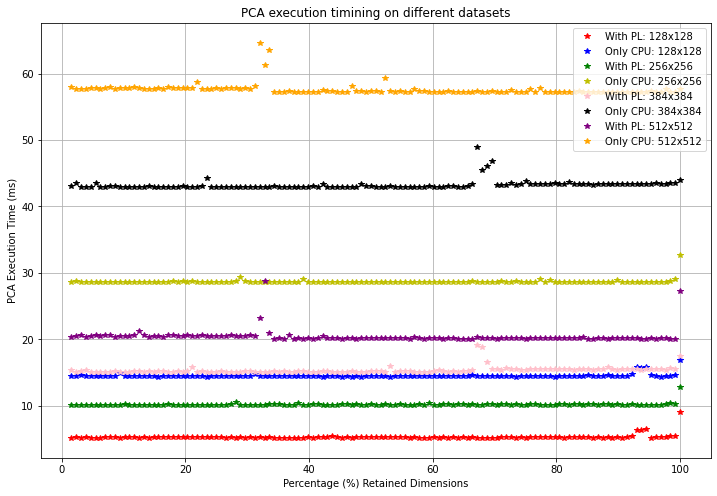

In [18]:
%matplotlib inline
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)

x = [100*x/128 for x in range(128, 1, -1)]

plt.plot(x, T11, '*', color = 'r')
plt.plot(x, T12, '*', color = 'b')

plt.plot(x, T21, '*', color = 'g')
plt.plot(x, T22, '*', color = 'y')

plt.plot(x, T31, '*', color = 'pink')
plt.plot(x, T32, '*', color = 'black')

plt.plot(x, T41, '*', color = 'purple')
plt.plot(x, T42, '*', color = 'orange')

plt.title("PCA execution timining on different datasets")
plt.xlabel("Percentage (%) Retained Dimensions")
plt.ylabel("PCA Execution Time (ms)")
plt.legend(["With PL: 128x128", "Only CPU: 128x128", "With PL: 256x256", "Only CPU: 256x256"
            , "With PL: 384x384", "Only CPU: 384x384", "With PL: 512x512", "Only CPU: 512x512"])
plt.grid()
plt.show()

# 

# Speedup demonstraion and Graph

In [19]:
t1 = t.time()
Y = PCA(X, dimension=128, Flag=True)  #with Pl
t2 = t.time()
T1 = t2 - t1
T1

0.007733821868896484

In [20]:
t1 = t.time()
Y2 = PCA(X, dimension=128, Flag=False)
t2 = t.time()
T2 = t2 - t1
T2

0.017046213150024414

In [21]:
(T2-T1)*1000

9.31239128112793

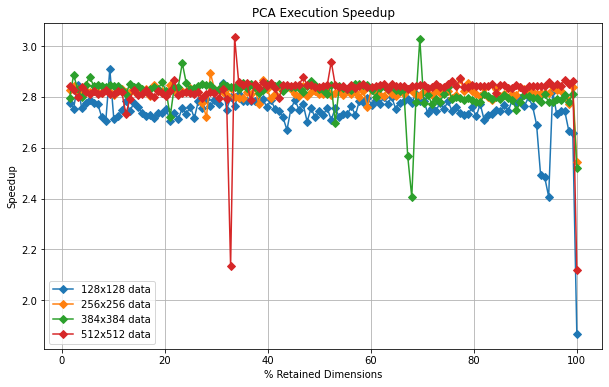

In [22]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)
plt.plot([100*x/128 for x in range(128, 1, -1)], T_diff, marker = 'D')
plt.plot([100*x/128 for x in range(128, 1, -1)], T_diff2, marker = 'D')
plt.plot([100*x/128 for x in range(128, 1, -1)], T_diff3, marker = 'D')
plt.plot([100*x/128 for x in range(128, 1, -1)], T_diff4, marker = 'D')


plt.title("PCA Execution Speedup")
plt.ylabel("Speedup")
plt.xlabel("% Retained Dimensions")
plt.legend(["128x128 data", "256x256 data", "384x384 data", "512x512 data"])
plt.grid()
plt.show()

# 

# Relative error b/w CPU and FPGA implemetation

In [23]:
Y

PynqBuffer([[-3.81125641e+01, -3.19427643e+02,  1.96413696e+02, ...,
              3.12111664e+00, -2.88746262e+00, -1.52587891e-05],
            [ 3.48083038e+02,  2.03183655e+02,  4.84924072e+02, ...,
              6.02304459e+00,  3.06880951e-01, -3.24249268e-05],
            [ 3.68396179e+02,  6.59693542e+02, -5.57834717e+02, ...,
             -5.39211655e+00, -3.54573631e+00,  1.04904175e-05],
            ...,
            [ 4.87451111e+02,  2.29593475e+02, -1.73792737e+03, ...,
              3.13303185e+00,  1.24231720e+00, -1.85966492e-05],
            [ 1.41237640e+02,  5.35310516e+01,  9.95749664e+01, ...,
             -4.80960464e+00,  2.47000599e+00,  1.62124634e-05],
            [-5.98184166e+01,  4.37333984e+02,  1.72150177e+02, ...,
             -2.33990622e+00, -1.49501562e+00,  1.26838684e-04]],
           dtype=float32)

In [24]:
Y2

array([[-3.81125772e+01, -3.19427647e+02,  1.96413680e+02, ...,
         3.12112255e+00, -2.88743007e+00,  1.34612321e-11],
       [ 3.48083010e+02,  2.03183657e+02,  4.84924000e+02, ...,
         6.02304715e+00,  3.06920847e-01,  4.45865567e-13],
       [ 3.68396292e+02,  6.59693654e+02, -5.57834878e+02, ...,
        -5.39216238e+00, -3.54567634e+00,  1.87370119e-11],
       ...,
       [ 4.87451163e+02,  2.29593476e+02, -1.73792722e+03, ...,
         3.13296794e+00,  1.24229630e+00, -7.72093500e-12],
       [ 1.41237687e+02,  5.35310296e+01,  9.95749578e+01, ...,
        -4.80961724e+00,  2.46996358e+00, -1.18687282e-11],
       [-5.98184291e+01,  4.37333866e+02,  1.72150207e+02, ...,
        -2.33985982e+00, -1.49503083e+00,  7.77244935e-12]])

In [25]:
Y-Y2

PynqBuffer([[ 1.31022703e-05,  4.20990051e-06,  1.64108253e-05, ...,
             -5.91174246e-06, -3.25425366e-05, -1.52588025e-05],
            [ 2.86438953e-05, -2.43306698e-06,  7.18643794e-05, ...,
             -2.56221822e-06, -3.98964847e-05, -3.24249272e-05],
            [-1.12745066e-04, -1.11082591e-04,  1.60951467e-04, ...,
              4.58317570e-05, -5.99728045e-05,  1.04903987e-05],
            ...,
            [-5.19823355e-05, -3.45878647e-07, -1.44555932e-04, ...,
              6.39095972e-05,  2.09016442e-05, -1.85966414e-05],
            [-4.62622056e-05,  2.20218496e-05,  8.63193068e-06, ...,
              1.25929627e-05,  4.24065928e-05,  1.62124752e-05],
            [ 1.25030431e-05,  1.18313748e-04, -3.01769121e-05, ...,
             -4.63960691e-05,  1.52065516e-05,  1.26838676e-04]])

In [26]:
Error = abs(np.around(Y-Y2, 15))
Error

array([[1.31022703e-05, 4.20990051e-06, 1.64108253e-05, ...,
        5.91174246e-06, 3.25425366e-05, 1.52588025e-05],
       [2.86438953e-05, 2.43306698e-06, 7.18643794e-05, ...,
        2.56221822e-06, 3.98964847e-05, 3.24249272e-05],
       [1.12745066e-04, 1.11082591e-04, 1.60951467e-04, ...,
        4.58317570e-05, 5.99728045e-05, 1.04903987e-05],
       ...,
       [5.19823355e-05, 3.45878647e-07, 1.44555932e-04, ...,
        6.39095972e-05, 2.09016442e-05, 1.85966414e-05],
       [4.62622056e-05, 2.20218496e-05, 8.63193068e-06, ...,
        1.25929627e-05, 4.24065928e-05, 1.62124752e-05],
       [1.25030431e-05, 1.18313748e-04, 3.01769121e-05, ...,
        4.63960691e-05, 1.52065516e-05, 1.26838676e-04]])

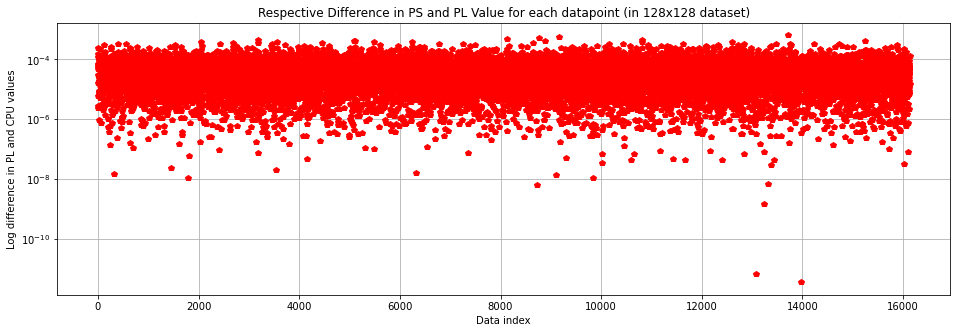

In [27]:
%matplotlib inline
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(5)
count = 0
for r in range(1, 128, 1):
    for c in range(1, 128, 1):
        plt.plot(count, Error[r][c], marker = 'p' ,color = 'r')
        count+=1
        
plt.grid()
plt.title("Respective Difference in PS and PL Value for each datapoint (in 128x128 dataset)")
plt.ylabel("Log difference in PL and CPU values")
plt.yscale("log")
plt.xlabel("Data index")
plt.show()

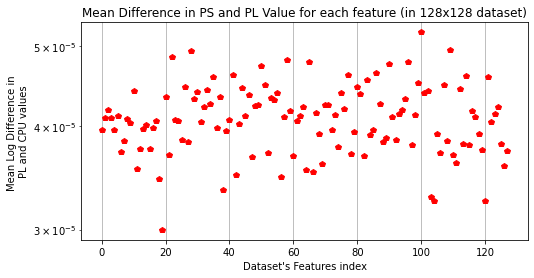

In [28]:
%matplotlib inline
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(4)
count = 0
for c in range(0, 128):
    plt.plot(count, np.mean(Error[:][c]), marker = 'p' ,color = 'r')
    count+=1

plt.title("Mean Difference in PS and PL Value for each feature (in 128x128 dataset)")
plt.grid()
plt.ylabel("Mean Log Difference in \nPL and CPU values")
plt.yscale("log")
plt.xlabel("Dataset's Features index")
plt.show()

# 

# A Rough T -Test 

In [29]:
Y = PCA(X, dimension=128, Flag=True) #with Pl
Y2 = PCA(X, dimension=128, Flag=False) #with CPU

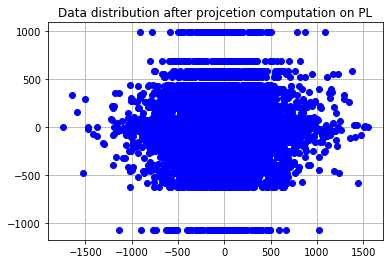

In [30]:
plt.plot(Y2,Y2[0][:], 'o', color = 'b')
plt.title("Data distribution after projcetion computation on PL")
plt.grid()
plt.show()

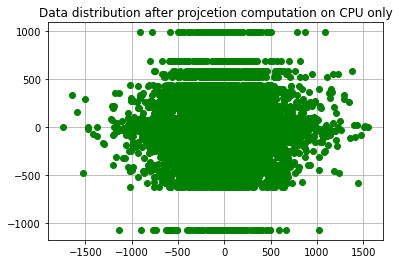

In [31]:
plt.plot(Y,Y[0][:], 'o', color = 'g')
plt.title("Data distribution after projcetion computation on CPU only")
plt.grid()
plt.show()

In [32]:
np.mean(Y), np.mean(Y2)    # differene in mean because PL and CPU values differ (Ideally mean = 0 : cause data centering)

(PynqBuffer(2.3841858e-07, dtype=float32), 4.6629367034256575e-15)

In [33]:
np.std(Y), np.std(Y2)

(PynqBuffer(284.18604, dtype=float32), 284.1860456073622)

In [34]:
np.var(Y), np.var(Y2)

(PynqBuffer(80761.71, dtype=float32), 80761.70851794974)

# 

# Comparision with scikit learn's PCA Function

#### for given TestData scikit learn's PCA reults:

In [35]:
from IPython.display import Image
Image(url="./Screen Shot 2023-04-30 at 4.51.31 PM.png", width=400, height=400)

#### for given TestData our PCA reults:

In [36]:
Cov, centerData = covariance(TestData)
eignVecInOrder = eigenVal(Cov)
Y2 = PCA(TestData, dimension=3, Flag=False)
Y2

array([[ 5.03466668e+03,  1.54927462e-02, -6.64399091e-16],
       [-2.19133333e+03, -1.87196092e-01, -5.27355937e-16],
       [-2.84333335e+03,  1.71703346e-01, -4.71844785e-16]])